I wished to do some machine learning for binary classification.
Binary classification is perhaps the most basic of all supervised learning problems.
Unsurprisingly julia has many libraries for it.
Today we are looking at:
LIBLINEAR (linear SVMs), LIBSVM (Kernel SVM), XGBoost (Extreme Gradient Boosting), DecisionTrees (RandomForests), Flux (neural networks), TensorFlow (also neural networks).
Most (infact I think all) of these do other things as well.
In this post we are only concentrating on their ability to be used for binary classification.
We'll also not really be going into exploring all their options (e.g. different types of kernals).
Furthermore, I'm not rigeriously tuning the hyperparameters so this can't be considered a fair test for performance.
I'm also not performing preprocessing (e.g. many classifies like it if you standarise your features to zero mean unit variance).
You can look at this post more as talking above *what code for that package looks like*, and this is roughly how long it takes and how well it does out of the box.
<!--more-->

## The Task: Predict if that part of the Australian Flag is Blue

This is on the mildly gnarly side of binary classification problems.
The classifying regions are:

 - Not linearly seperable
    - you can't draw a line such that on one since is all the blue parts and on the other is all the nonblue parts.
 - Not connected
    - the stars for example are not entirely separated by blue background regions
 - Not convex 
    - with in a section of one color, you can draw a line between two points and have it exit that section, then reenter.
 - Unbalanced classes
    - most of the image is blue)
 
So it seams like a good problem.

![Australian Flag](https://upload.wikimedia.org/wikipedia/en/thumb/b/b9/Flag_of_Australia.svg/800px-Flag_of_Australia.svg.png)

### Data Generation
An image of the flag gives us one datum per pixel.
We're going to sample that, just so that plotting is easier.

In [1]:
using Images, FileIO

In [2]:
img = load(download("https://upload.wikimedia.org/wikipedia/en/thumb/b/b9/Flag_of_Australia.svg/320px-Flag_of_Australia.svg.png"));

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

In [3]:
isblue(pixel) = pixel.b > pixel.r && pixel.b > pixel.g

isblue (generic function with 1 method)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] !(::BitArray{2}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] include_string(::Module, ::String, ::String) at /home/wheel/oxinabox/.julia/v0.6/Compat/src/Compat.jl:174
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/wheel/oxinabox/.julia/v0.6/IJulia/src/execute_request.jl:154
 [6] eventloop(::ZMQ.Socket) at /home/wheel/oxinabox/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[4], in expression starting on line 1


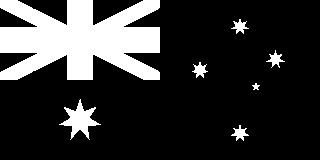

In [4]:
colorview(Gray, !(isblue.(img)))

In [5]:
const all_feature1 = Vector{Float64}()
const all_feature2 = Vector{Float64}()
const all_labels = Vector{Bool}()

@inbounds for ind in eachindex(IndexCartesian(), img)
    pixel = img[ind]
    push!(all_labels, isblue(pixel))
    push!(all_feature1, ind.I[1])
    push!(all_feature2, ind.I[2])
end

const all_features = [all_feature1'; all_feature2']
# standard julia Observations are in final index form (i.e columns of matrixes)
Any[all_features; all_labels']

3×51200 Array{Any,2}:
     1.0      2.0      3.0      4.0  …   157.0   158.0   159.0   160.0
     1.0      1.0      1.0      1.0      320.0   320.0   320.0   320.0
 false    false    false    false       true    true    true    true  

Normally I would do this data munging using MLDataUtils.jl, which I have [blogged about before](http://white.ucc.asn.au/2017/01/24/JuliaML-and-TensorFlow-Tuitorial.html) (though it might be nice to few more posts about it, it is a great package, and I don't know that I've fully covered its capacities).

But since I am already about to introduce 6 packages, I thought I would minimize talking about other ones.

In [6]:
const all_inds = shuffle(1:length(all_labels))
const test_inds = all_inds[1:end÷5] # first 20%
const train_inds = all_inds[9end÷10:end] # last 10%

const test_features = all_features[:, test_inds]
const test_labels = all_labels[test_inds]

const train_features = all_features[:, train_inds]
const train_labels = all_labels[train_inds];

In [7]:
using Plots
gr()

function plotflag(xs,ys)
    scatter(xs[2,:],-xs[1,:]; zcolor=ys,
    markersize=2, markerstrokealpha=0, bg=colorant"gray", seriescolor=:blues)
end


In [8]:
#plotflag(train_features, train_labels)

In [9]:
#plotflag(test_features, test_labels)

## Interface
As was discussed on the julia slack yesterday.
There is a real problem with a lack of consistency.

So I am going to take a leaf from XKCD #927,
and define one.
![Standards](https://imgs.xkcd.com/comics/standards.png)

 - `StatsBase.fit!(modeltype, features, labels)` returns a model of that type that is trained on those features and labels.
    - Since we are only interested in binary classification, labels witll be an `AbstractVector{Bool}` with one entry per column of the feature matrix
 - `StatsBase.predict(model, features)` returns a vector of estimated probabilities of classification being true
    - one entry per column in features.

Something like this is actually in use in a bunch of places already, just not these packages, it seems..
Some packages (`LibSVM`, `DecisionTrees.jl`) use the same names, from [`ScikitLearnBase`](https://github.com/cstjean/ScikitLearnBase.jl), but they go sideways (i.e. observations in rows, Python style).
I think the real solution to a good interface does need to be thinking more like (or using) MLDataUtils.jl, which is Observation dimention agnostic, defaulting to normal julia practice (`ObsDim.Last()`).

Using these we can define our metrics, etc.
It might be nicer to be using [MLMetrics.jl](https://github.com/JuliaML/MLMetrics.jl/) to do this for us.
But I'll just do it simply here.

In [10]:
import StatsBase: fit!, predict

classify(model, features) = predict(model, features).>0.5
accuracy(model, features, ground_truth_labels) = mean(classify(model, features) .== ground_truth_labels)

accuracy (generic function with 1 method)

#### Evaluation function
Given a common interface we can write one function to evaluate them all.  
Accessing our training and test data as a global variable.
(Obviously not a good idea normally).

In [11]:
percent(x) = @sprintf("%0.2f%%", 100*x)

function evaluate(modeltype)    
    @time model = fit!(modeltype, train_features, train_labels)
    
    println("$modeltype Train accuracy: ", percent(accuracy(model, train_features, train_labels)))
    println("$modeltype Test accuracy: ", percent(accuracy(model, test_features, test_labels)))
end

evaluate (generic function with 1 method)

## [LIBLINEAR.jl](https://github.com/innerlee/LIBLINEAR.jl)

Linear SVM.
A great first shot for classification.
It surprises me that the C backend was only created in 2008.

R.-E. Fan, K.-W. Chang, C.-J. Hsieh, X.-R. Wang, and C.-J. Lin.
LIBLINEAR: A Library for Large Linear Classification, Journal of
Machine Learning Research 9(2008), 1871-1874. Software available at
http://www.csie.ntu.edu.tw/~cjlin/liblinear


Because we are interesting in getting probabilities back from `predict`
we are restricted to using `L2R_LR` and `L1R_LR` solver types, which are logistric regression.
This could probably be relaxed for most applications (but might break those metrics defintions above).


In [12]:
using LIBLINEAR
function fit!(::Type{LinearModel}, features, labels; solver_type=LIBLINEAR.L2R_LR, kwargs...)
    linear_train(labels, features; solver_type=solver_type, kwargs...)
end

function predict(model::LinearModel, features)
    classes, probs = linear_predict(model, features; probability_estimates=true)
    vec(probs)
end

predict (generic function with 2 methods)

In [13]:
evaluate(LinearModel)

  0.576060 seconds (31.21 k allocations: 1.764 MiB)
LIBLINEAR.LinearModel Train accuracy: 19.57%
LIBLINEAR.LinearModel Test accuracy: 19.86%


## [LIBSVM.jl](https://github.com/mpastell/LIBSVM.jl)

The more general SVM package.
We're here for its kernal SVM classifers.
Again I am surprised that the backend was created so recently: 2005

Since version 2.8, it implements an SMO-type algorithm proposed in this paper:
R.-E. Fan, P.-H. Chen, and C.-J. Lin. Working set selection using second order information for training SVM. Journal of Machine Learning Research 6, 1889-1918, 2005.
https://www.csie.ntu.edu.tw/~cjlin/libsvm/


We're looking at `SVC`, in this example.
The other types of interst here would be `NuSVC`, and `LinearSVC` (but we got that covered by LIBLINEAR)


In [14]:
import LIBSVM:svmtrain, SVM, svmpredict
function fit!(::Type{SVM{Bool}}, features, labels; solver_type=LIBLINEAR.L2R_LR, kwargs...)
    #could use ScikitLearnBase.fit!(SVC, features, Float64.(labels)), but it doesn't take extra args same way.
    svmtrain(features, labels; probability=true, kwargs...)
end

function predict(model::SVM{Bool}, features)
    classes, probs = svmpredict(model, features)
    probs[1,:]
end

predict (generic function with 3 methods)

In [15]:
evaluate(SVM{Bool})

 19.697385 seconds (131.22 k allocations: 7.247 MiB)
LIBSVM.SVM{Bool} Train accuracy: 0.02%
LIBSVM.SVM{Bool} Test accuracy: 

## [DecisionTree.jl](https://github.com/bensadeghi/DecisionTree.jl)
Shallow decision trees are one of the only ML systems, that are not black box.
Anyone can look in and see how they work.
And while, the human domain expert might not make those rules themselves, they can say that "yes those rules make sense".
This makes DecisionTrees way easier to "sell" to a consumer.

This package has pruned trees, random forests and adaptive-boosted decision stumps.  
They are all useful; and all suitable.  I've not evaluating the `AdaBoostStumpClassifier` as when I tried it threw errors.
I'm going to just wrap the ScikitLearnBase interface here, as DecisionTree.jl seems to be alwary sideway anyway.

In [16]:
using DecisionTree
import ScikitLearnBase

function fit!(model::ScikitLearnBase.BaseClassifier, features, labels)
    #could use ScikitLearnBase.fit!(SVC, features, Float64.(labels)), but it doesn't take extra args same way.
    ScikitLearnBase.fit!(model, features', labels)
end

function predict(model::ScikitLearnBase.BaseClassifier, features)
    ScikitLearnBase.predict_proba(model, features')[:,2]
end

#Use default settings if just give type
function fit!(kind::Type{<:ScikitLearnBase.BaseClassifier}, features, labels)
    fit!(kind(), features, labels)
end

fit! (generic function with 5 methods)

In [17]:
evaluate(RandomForestClassifier)

  4.066056 seconds (1.76 M allocations: 126.120 MiB, 5.00% gc time)
DecisionTree.RandomForestClassifier Train accuracy: 99.51%
DecisionTree.RandomForestClassifier Test accuracy: 97.62%


In [18]:
evaluate(DecisionTreeClassifier)

  0.080683 seconds (39.47 k allocations: 6.837 MiB)
DecisionTree.DecisionTreeClassifier Train accuracy: 100.00%
DecisionTree.DecisionTreeClassifier Test accuracy: 97.29%


## [XGBoost.jl](https://github.com/dmlc/XGBoost.jl)
eXtreme Gradient Boosting.  
These are boosting tree ensembles.
They are all about adding extra rules to just handling the errors existing rules don't catch.
This basically makes training fast, and simply improves the results.


They win Kraggle all the time. Though today they lose the the plain old random forest.

Right now, it hasn't had a release tagged, so is broken on julia 0.6
This can be solved using `Pkg.checkout("XGBoost"); Pkg.build("XGBoost")`.

In [39]:
import XGBoost: xgboost, Booster

In [61]:
function fit!(::Type{Booster}, features, labels; num_rounds=16, eta=1, max_depth = 16, kwargs...)
    xgboost(features', num_rounds; label=labels, objective = "binary:logistic",  eta=eta, max_depth=max_depth, silent=true, kwargs...)
end

function predict(model::Booster, features)
    XGBoost.predict(model, features')
end

predict (generic function with 5 methods)

In [62]:
evaluate(Booster)

  4.442814 seconds (3.29 k allocations: 348.875 KiB)
XGBoost.Booster Train accuracy: 99.98%
XGBoost.Booster Test accuracy: 97.62%


## [TensorFlow.jl](https://github.com/malmaud/TensorFlow.jl)
TensorFlow.jl is my baby: Ok it is actually [@malmaud's](http://www.malmaud.com/) baby.
I guess I'm that cool uncle :-P that teach's it how to make slingshots and things; or in this case do julia-style indexing and such.

Using a neural network to do classification is a bit like driving a tank to the shops.
Sure it will get you there; and nothing can ever stop you getting there. But it's not exactly fast.
So maybe you stop and give up before reaching the store.

Since it is a general Neural Net framework (and a low level one at that), we have to build the classifier ourself.

In [64]:
using TensorFlow

struct TensorFlowClassifier
    xs::Tensor{Float32}
    ys::Tensor{Float32}
    sess::Session
end

INFO: Recompiling stale cache file /home/wheel/oxinabox/.julia/lib/v0.6/TensorFlow.ji for module TensorFlow.


In [69]:
sess = Session()

nfeatures = 4
@tf begin
    xs = placeholder(Float32, shape=[nfeatures, -1]) #Nfeatures, Nsamples (going to use julian ordering)
    z1 = xs
    
    W1 = get_variable([nfeatures^2, nfeatures], Float32)
    b1 = get_variable([nfeatures^2], Float32)
    z2 = nn.relu(W1*z1+b1)
    
    W2 = get_variable([nfeatures^2, nfeatures^2], Float32)
    b2 = get_variable([nfeatures^2], Float32)
    z3 =  nn.relu(W2*z2+b2)
    
    W3 = get_variable([1, nfeatures^2], Float32)
    b3 = get_variable([nfeatures^2], Float32)
    ys = nn.sigmoid(W3*z3+b3)

    ys_targets = placeholder(Float32, shape=[1, -1])
    loss = nn.sigmoid_cross_entropy_with_logits(;logits=ys, targets=ys_targets)
end 

2017-12-14 17:05:39.966669: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-14 17:05:39.966698: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.


<Tensor loss/Add_5:1 shape=(1, ?) dtype=Float32>

In [65]:
relu

LoadError: [91mUndefVarError: relu not defined[39m

In [68]:
?nn.sigmoid_cross_entropy_with_logits 

No documentation found.

`TensorFlow.nn.sigmoid_cross_entropy_with_logits` is a `Function`.

```
# 2 methods for generic function "sigmoid_cross_entropy_with_logits":
sigmoid_cross_entropy_with_logits(; logits, targets, name) in TensorFlow.nn at /home/wheel/oxinabox/.julia/v0.6/TensorFlow/src/ops/nn.jl:195
sigmoid_cross_entropy_with_logits(logits, targets; kwargs...) in TensorFlow.nn at deprecated.jl:56
```
